In [1]:
from typing import List, Dict

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorly as tl
from gluonts.dataset.util import to_pandas


from tens_utils import (
    get_gluonts_dataset,
    mad,
    rmse, 
    get_param_sweep,
    trend_cycle_decompose,
)

from forecaster import (
    DCTForecaster, DFTForecaster, HoltWintersForecaster, CPForecaster, TuckerForecaster
)
from experiment import SingleForecasterExperiment

In [2]:
train_datas, test_datas, lens, freqs = get_gluonts_dataset(dataset_name="electricity")

INFO:root:using dataset already processed in path /Users/caner/.mxnet/gluon-ts/datasets/electricity.


21044    321
dtype: int64
H    321
dtype: int64


In [84]:
FOLDS = (24, 7)
NR_IN_CYCLES = 120

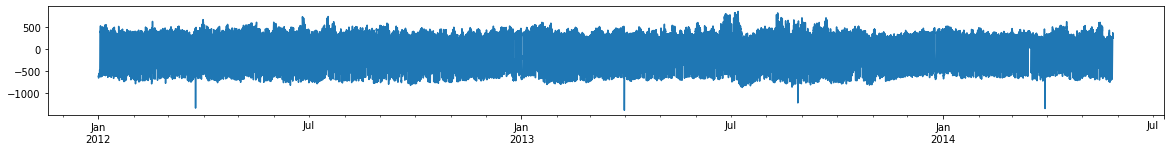

In [85]:
orig_data = to_pandas(test_datas[171])
tc, vals = trend_cycle_decompose(orig_data, w=int(2 * np.prod(FOLDS)))

# vals = vals / (vals.max() - vals.min())  # scale the residuals

vals.plot(figsize=(20, 2))

In [86]:
dft_sweep = get_param_sweep(int(np.prod(FOLDS)), "log", 100)
tensor_sweep = list(range(1, 6))
# constant_sweep = [1]

In [89]:
experiments = [
    SingleForecasterExperiment(
        DCTForecaster,
        dft_sweep,
        folds=FOLDS,
    ),
    SingleForecasterExperiment(
        DFTForecaster,
        dft_sweep,
        folds=FOLDS,
    ),
    SingleForecasterExperiment(
        CPForecaster,
        tensor_sweep,
        folds=FOLDS,
    ),
    SingleForecasterExperiment(
        TuckerForecaster,
        tensor_sweep,
        folds=FOLDS,
    ),
#     SingleForecasterExperiment(
#         HoltWintersForecaster,
#         [1],
#         folds=FOLDS,
#     ),
]

DCTForecaster
-- in sample --
min rmse: 100.958
min mad: 68.767
-- out of sample --
min rmse: 136.763
min mad: 105.732
DFTForecaster
-- in sample --
min rmse: 88.226
min mad: 59.378
-- out of sample --
min rmse: 104.990
min mad: 76.428
CPForecaster
-- in sample --
min rmse: 72.398
min mad: 50.262
-- out of sample --
min rmse: 113.165
min mad: 81.664
TuckerForecaster
-- in sample --
min rmse: 102.742
min mad: 65.948
-- out of sample --
min rmse: 100.472
min mad: 71.547


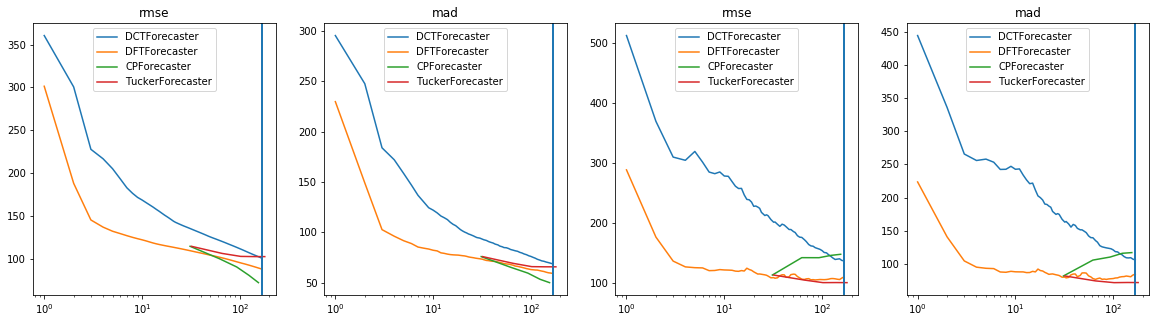

In [90]:
def plot_results(ax, pars, scores, label):
    if len(pars) == 1:
        ax.axhline(scores[0], label=label, color='gray', linestyle='--')
    else:
        ax.plot(pars, scores, label=label)

f, ax = plt.subplots(1, 4, figsize=(20, 5))
for exp in experiments:
    ins, outs, pars, _ = exp(vals, nr_in_cycles=NR_IN_CYCLES)
    
    plot_iterator = zip(
        list(ins.keys()) + list(outs.keys()), 
        list(ins.values()) + list(outs.values()), 
        ax
    )
    
    for fn, scores, ax_ in plot_iterator:
        plot_results(ax_, pars, scores, label=exp.forecaster_class.__name__)
        ax_.set(title=fn)
        ax_.legend()
        ax_.axvline(np.prod(FOLDS))
        ax_.semilogx()
        
    print(exp.forecaster_class.__name__)
    print("-- in sample --")
    for k in ins:
        print(f"min {k}: {np.min(ins[k]):.3f}")
        
    print("-- out of sample --")
    for k in outs:
        print(f"min {k}: {np.min(outs[k]):.3f}")